# CPA vs MultiCPA

In [1]:
import sys
sys.path.append("../../multicpa")

In [2]:
import os
import pandas as pd
import warnings
import numpy as np
import torch
import scanpy as sc
import anndata as ad
from sklearn.metrics import r2_score

In [3]:
from MultiCPA.helper import model_importer
from MultiCPA.plotting import CompertVisuals
from MultiCPA.api import ComPertAPI
from MultiCPA.plotting import ComPertHistory

In [4]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [6]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [7]:
DATAM = {'papalexi': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert12',
                    'nt_condition': "THP-1_NT_1.0"},
        'wessel': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_prep.h5ad', 'seml': 'mpert15',
                  'nt_condition': "THP-1_NT_1"},
        'wessel_ood': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_prep.h5ad', 'seml': 'mpert16',
                  'nt_condition': "THP-1_NT_1"},
        'wessel_ood_noprot': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_noprot_prep.h5ad', 'seml': 'mpert17',
                  'nt_condition': "THP-1_NT_1"},
        'papalexi_all': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert18',
                    'nt_condition': "THP-1_NT_1.0"},
       }

In [8]:
torch.cuda.is_available()

False

# Loading CPA

In [9]:
dataset = 'wessel_ood_noprot'
DATA = DATAM[dataset]

mulpert_models = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/{DATA['seml']}_pickled.pk")
spt = 'test'
focus_metric_1 = f"{spt}_mean_score_genes_last"

mulpert_models = mulpert_models[(mulpert_models['status'] == 1)]
mulpert_models = mulpert_models[mulpert_models[focus_metric_1] > 0]
mulpert_models["overall_best"] = np.sqrt(mulpert_models[focus_metric_1]**2)

top_top = 5
mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)[:top_top]
mulpert_models[["config.model.model_type", f"{'ood'}_mean_score_genes_last", f"{'ood'}_mean_score_proteins_last", f"{'training'}_mean_score_genes_last", f"{'training'}_mean_score_proteins_last", f"{'test'}_mean_score_genes_last", f"{'test'}_mean_score_proteins_last", "overall_best"]]

,config.model.model_type,ood_mean_score_genes_last,ood_mean_score_proteins_last,training_mean_score_genes_last,training_mean_score_proteins_last,test_mean_score_genes_last,test_mean_score_proteins_last,overall_best
_id,,,,,,,,
7537,ComPert,0.964935,0.0,0.975032,0.0,0.948357,0.0,0.948357
8240,ComPert,0.961133,0.0,0.976453,0.0,0.948346,0.0,0.948346
8601,ComPert,0.955558,0.0,0.976509,0.0,0.948129,0.0,0.948129
387,ComPert,0.956186,0.0,0.974227,0.0,0.947933,0.0,0.947933
8783,ComPert,0.960145,0.0,0.974647,0.0,0.947109,0.0,0.947109


In [10]:
chosen_model = mulpert_models.index[0]
print(chosen_model)

7537


In [11]:
chosen_model_entry = mulpert_models.loc[chosen_model]
cpa_autoencoder, cpa_datasets, cpa_state, cpa_history, cpa_hypers = \
    model_importer(chosen_model, mulpert_models, 
                   model_dir=f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/_last/", 
                   dataset_relative_to="/home/icb/kemal.inecik/work/codes/multicpa-reproducibility",
                  model_created="ComPert")
print(cpa_hypers['hparams']['adversary_wd'] == mulpert_models.loc[chosen_model]['config.model.model_args.hparams.adversary_wd'])

/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/notebooks/../../multicpa/MultiCPA/data.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/torch/csrc/utils/tensor_new.cpp:201.)
  self.drugs = torch.Tensor(drugs)


True


In [12]:
cpa_hypers

{'dataset_path': '/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/datasets/Wessel22_noprot_prep.h5ad',
 'cell_type_key': 'cell_type',
 'split_key': 'split2',
 'perturbation_key': 'condition',
 'dose_key': 'dose_val',
 'checkpoint_freq': 100,
 'max_epochs': 1200,
 'max_minutes': 900,
 'patience': 100,
 'loss_ae': 'nb',
 'doser_type': 'linear',
 'save_dir': '/storage/groups/ml01/workspace/kemal.inecik/seml/mpert17/_last',
 'decoder_activation': 'linear',
 'seed': 743039734,
 'raw_counts_key': 'counts',
 'is_vae': True,
 'protein_key': 'protein_expression',
 'raw_protein_key': 'protein_expression_raw',
 'hparams': {'dim': 256,
  'dosers_width': 128,
  'dosers_depth': 1,
  'dosers_lr': 0.0004205126127262943,
  'dosers_wd': 9.049464636503721e-07,
  'autoencoder_width': 256,
  'autoencoder_depth': 4,
  'adversary_width': 256,
  'adversary_depth': 4,
  'reg_adversary': 0.011882246283700321,
  'penalty_adversary': 0.08061894779664387,
  'autoencoder_lr': 7.365162806064072e-05,
  'ad

# Loading Mulpert

In [13]:
mulpert_models.columns

Index(['config.overwrite', 'config.db_collection',
       'config.dataset.dataset_args.cell_type_key',
       'config.dataset.dataset_args.counts_key',
       'config.dataset.dataset_args.dataset_path',
       'config.dataset.dataset_args.dose_key',
       'config.dataset.dataset_args.perturbation_key',
       'config.dataset.dataset_args.proteins_key',
       'config.dataset.dataset_args.raw_proteins_key',
       'config.dataset.dataset_args.split_key',
       'config.model.model_args.decoder_activation',
       'config.model.model_args.doser_type',
       'config.model.model_args.hparams.adversary_depth',
       'config.model.model_args.hparams.adversary_lr',
       'config.model.model_args.hparams.adversary_steps',
       'config.model.model_args.hparams.adversary_wd',
       'config.model.model_args.hparams.adversary_width',
       'config.model.model_args.hparams.autoencoder_depth',
       'config.model.model_args.hparams.autoencoder_lr',
       'config.model.model_args.hparams.au

In [14]:
dataset = 'wessel_ood'
DATA = DATAM[dataset]

mulpert_models = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/{DATA['seml']}_pickled.pk")
spt = 'test'
focus_metric_1 = f"{spt}_mean_score_genes_last"
focus_metric_2 = f"{spt}_mean_score_proteins_last"

mulpert_models = mulpert_models[(mulpert_models['status'] == 1)]
mulpert_models = mulpert_models[(mulpert_models[focus_metric_1] > 0) & (mulpert_models[focus_metric_2] > 0)]
mulpert_models["overall_best"] = np.sqrt(mulpert_models[focus_metric_1]**2 + mulpert_models[focus_metric_2]**2)

top_top = 5
mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)[:top_top]
mulpert_models[["config.model.model_type", f"{'ood'}_mean_score_genes_last", f"{'ood'}_mean_score_proteins_last", f"{'training'}_mean_score_genes_last", f"{'training'}_mean_score_proteins_last", f"{'test'}_mean_score_genes_last", f"{'test'}_mean_score_proteins_last", "overall_best"]]

,config.model.model_type,ood_mean_score_genes_last,ood_mean_score_proteins_last,training_mean_score_genes_last,training_mean_score_proteins_last,test_mean_score_genes_last,test_mean_score_proteins_last,overall_best
_id,,,,,,,,
12600,TotalComPert,0.966469,0.987495,0.979036,0.992201,0.950628,0.989438,1.372108
523,TotalComPert,0.958885,0.989729,0.974262,0.997580,0.946808,0.991967,1.371293
146,TotalComPert,0.952903,0.985075,0.974326,0.997993,0.946064,0.990685,1.369851
161,TotalComPert,0.953077,0.992664,0.974665,0.997942,0.945947,0.988619,1.368277
12609,TotalComPert,0.940798,0.992355,0.970010,0.999067,0.942726,0.991082,1.367836


In [15]:
chosen_model = mulpert_models.index[0]
print(chosen_model)

12600


In [16]:
chosen_model_entry = mulpert_models.loc[chosen_model]
mul_autoencoder, mul_datasets, mul_state, mul_history, mul_hypers = \
    model_importer(chosen_model, mulpert_models, 
                   model_dir=f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/_last/", 
                   dataset_relative_to="/home/icb/kemal.inecik/work/codes/multicpa-reproducibility")
print(mul_hypers['hparams']['adversary_wd'] == mulpert_models.loc[chosen_model]['config.model.model_args.hparams.adversary_wd'])

True


In [17]:
mul_hypers

{'dataset_path': '/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/datasets/Wessel22_prep.h5ad',
 'cell_type_key': 'cell_type',
 'split_key': 'split2',
 'perturbation_key': 'condition',
 'dose_key': 'dose_val',
 'checkpoint_freq': 100,
 'max_epochs': 1200,
 'max_minutes': 900,
 'patience': 100,
 'loss_ae': 'nb',
 'doser_type': 'linear',
 'save_dir': '/storage/groups/ml01/workspace/kemal.inecik/seml/mpert16/_last',
 'decoder_activation': 'linear',
 'seed': 414221597,
 'raw_counts_key': 'counts',
 'is_vae': True,
 'protein_key': 'protein_expression',
 'raw_protein_key': 'protein_expression_raw',
 'hparams': {'dim': 256,
  'dosers_width': 128,
  'dosers_depth': 3,
  'dosers_lr': 0.0011968999472599176,
  'dosers_wd': 4.436923520712216e-08,
  'autoencoder_width': 512,
  'autoencoder_depth': 4,
  'adversary_width': 128,
  'adversary_depth': 4,
  'reg_adversary': 50.63822618159138,
  'penalty_adversary': 0.031460907752441224,
  'autoencoder_lr': 0.00019083560935576104,
  'adversary_

# History

In [18]:
mul_pretty_history = ComPertHistory(mul_history)
cpa_pretty_history = ComPertHistory(cpa_history)

In [19]:
mul_pretty_history.print_time()
cpa_pretty_history.print_time()  # run on cpu

Computation time: 200 min
Computation time: 309 min


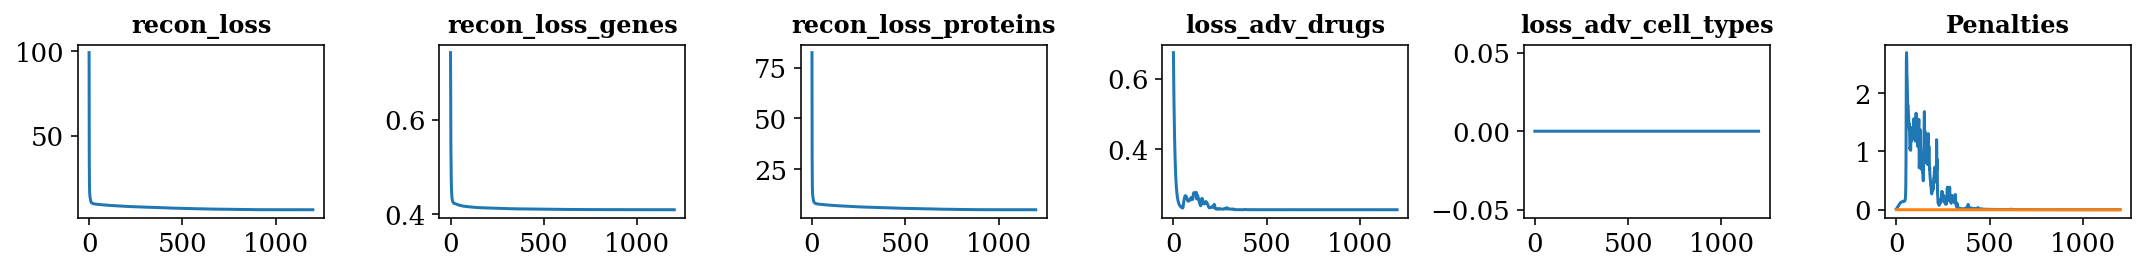

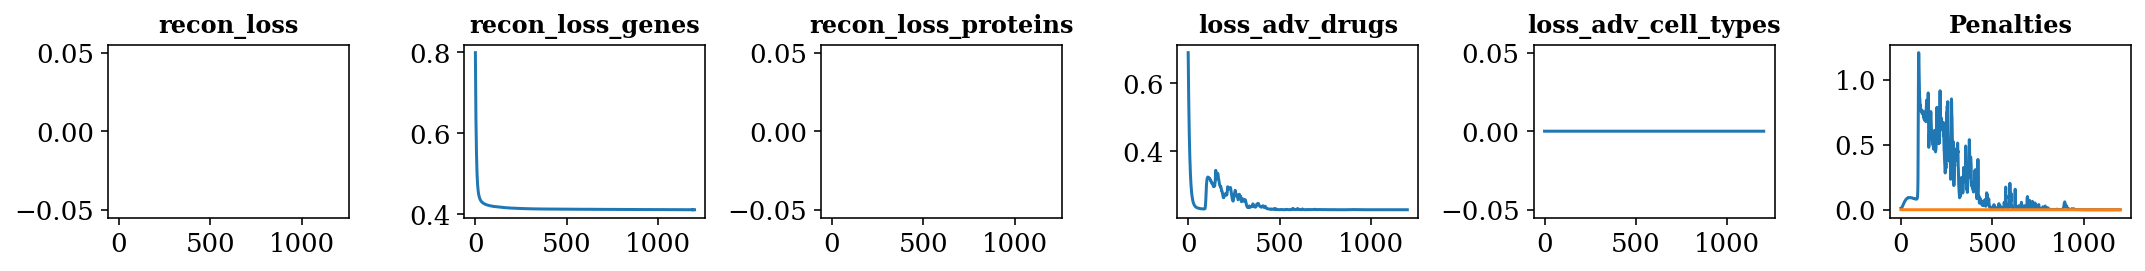

In [20]:
mul_pretty_history.plot_losses()
cpa_pretty_history.plot_losses()

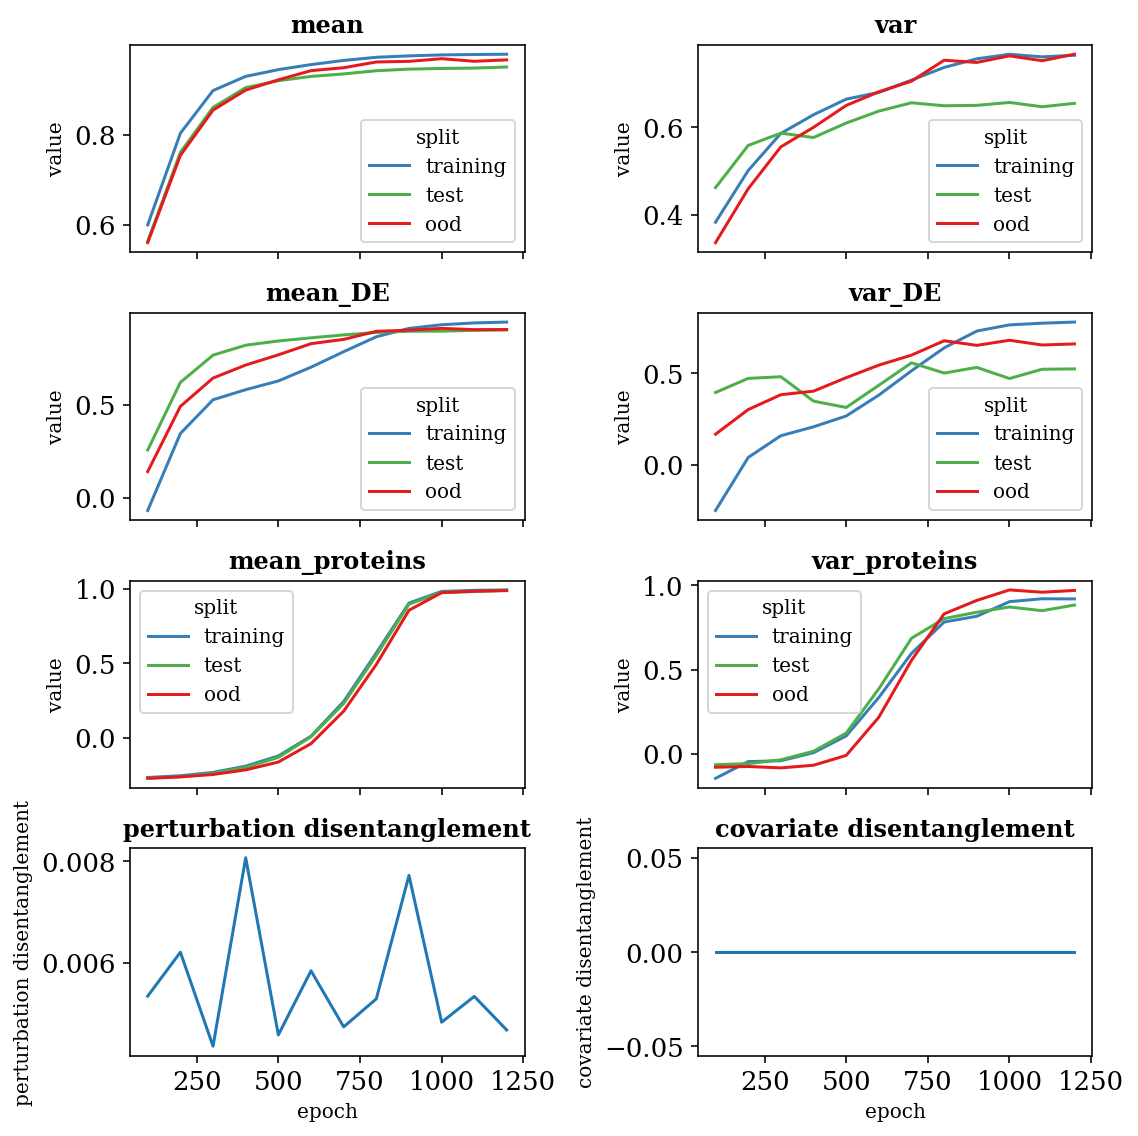

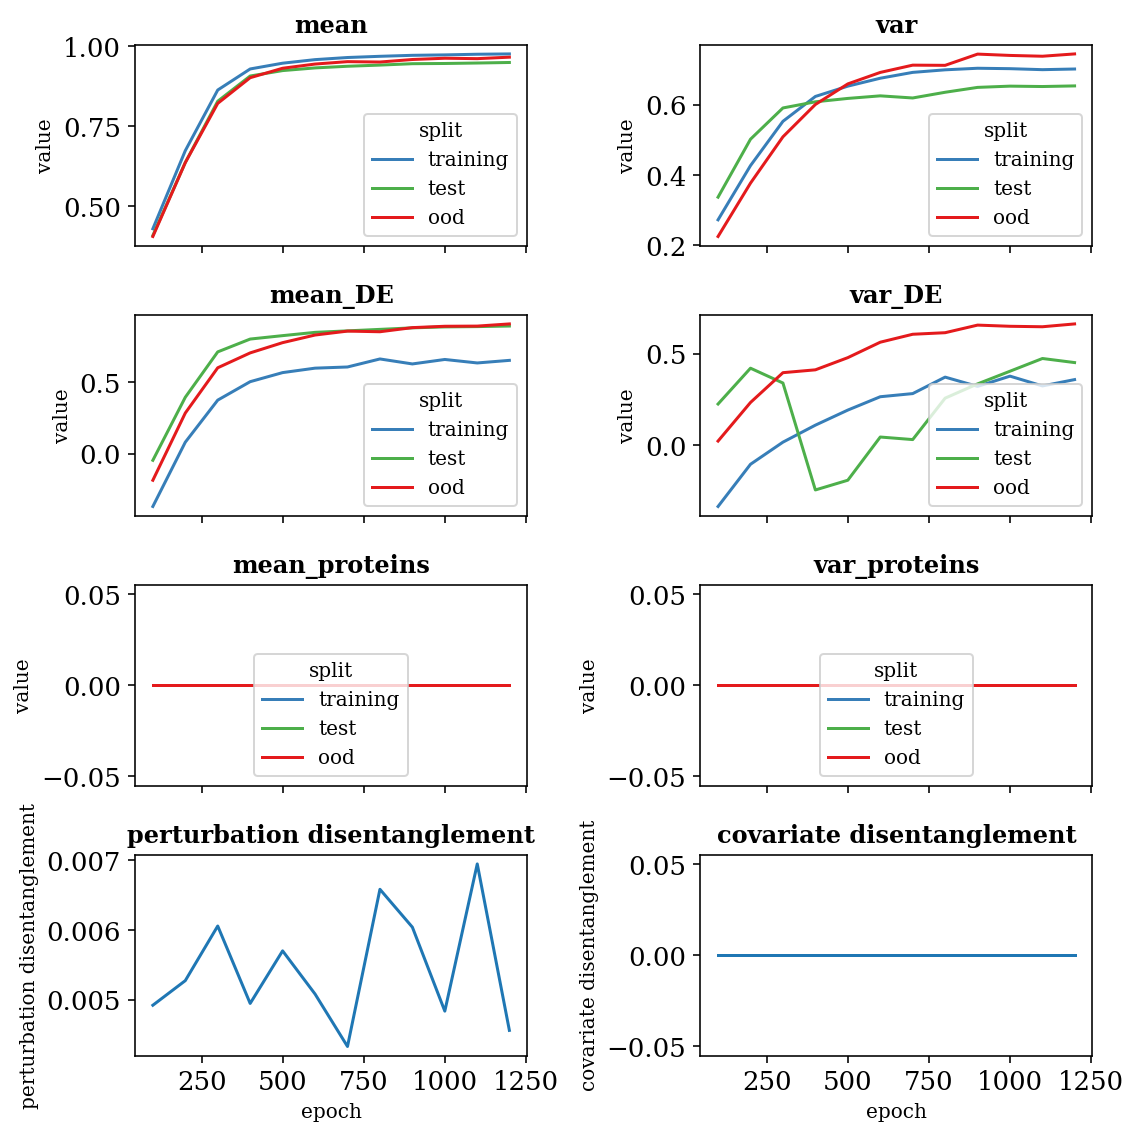

In [21]:
mul_pretty_history.plot_metrics(epoch_min=0)
cpa_pretty_history.plot_metrics(epoch_min=0)

# Latent Space

In [22]:
raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))

In [23]:
spt = "training"

dataset = cpa_datasets[spt]
genes = cpa_datasets[spt].raw_genes
proteins = cpa_datasets[spt].raw_proteins
num, dim_genes = genes.size(0), genes.size(1)
emb_drugs = dataset.drugs.clone()
emb_cts = dataset.cell_types.clone()

genes, drugs, cell_types, proteins, _, _ = cpa_autoencoder.move_inputs_(genes, emb_drugs, emb_cts, proteins, None, None)
encoder_input = torch.cat([genes, proteins], dim=-1)
latent_basal = cpa_autoencoder.encoder(encoder_input)

latent_mean = None
latent_log_var = None
use_latent_mean = True
if cpa_autoencoder.is_vae:
    # convert variance estimates to a positive value in [1e-3, \infty)
    dim = latent_basal.size(1) // 2
    latent_basal[:, dim:] = \
        latent_basal[:, dim:].exp().add(1).log().add(1e-3)
    latent_mean = latent_basal[:, :dim]
    latent_log_var = latent_basal[:, dim:].log()
    latent_basal = cpa_autoencoder.reparameterize(latent_mean, latent_log_var)
    if use_latent_mean:
        latent_basal = latent_mean

drug_emb = cpa_autoencoder.compute_drug_embeddings_(drugs)
cell_emb = cpa_autoencoder.cell_type_embeddings(cell_types.argmax(1))
latent_treated = latent_basal + drug_emb + cell_emb
cpa_latent_treated, cpa_latent_basal = latent_treated.clone(), latent_basal.clone()
cpa_latent_treated = ad.AnnData(cpa_latent_treated.numpy(), obs=adata[adata.obs['split2'] == 'train'].obs)
cpa_latent_basal = ad.AnnData(cpa_latent_basal.numpy(), obs=adata[adata.obs['split2'] == 'train'].obs)

In [24]:
spt = "training"

dataset = mul_datasets[spt]
genes = mul_datasets[spt].raw_genes
proteins = mul_datasets[spt].raw_proteins
num, dim_genes = genes.size(0), genes.size(1)
emb_drugs = dataset.drugs.clone()
emb_cts = dataset.cell_types.clone()

genes, drugs, cell_types, proteins, _, _ = mul_autoencoder.move_inputs_(genes, emb_drugs, emb_cts, proteins, None, None)
encoder_input = torch.cat([genes, proteins], dim=-1)
latent_basal = mul_autoencoder.encoder(encoder_input)

latent_mean = None
latent_log_var = None
use_latent_mean = True
if mul_autoencoder.is_vae:
    # convert variance estimates to a positive value in [1e-3, \infty)
    dim = latent_basal.size(1) // 2
    latent_basal[:, dim:] = \
        latent_basal[:, dim:].exp().add(1).log().add(1e-3)
    latent_mean = latent_basal[:, :dim]
    latent_log_var = latent_basal[:, dim:].log()
    latent_basal = mul_autoencoder.reparameterize(latent_mean, latent_log_var)
    if use_latent_mean:
        latent_basal = latent_mean

drug_emb = mul_autoencoder.compute_drug_embeddings_(drugs)
cell_emb = mul_autoencoder.cell_type_embeddings(cell_types.argmax(1))
latent_treated = latent_basal + drug_emb + cell_emb
mul_latent_treated, mul_latent_basal = latent_treated.clone(), latent_basal.clone()
mul_latent_treated = ad.AnnData(mul_latent_treated.numpy(), obs=adata[adata.obs['split2'] == 'train'].obs)
mul_latent_basal = ad.AnnData(mul_latent_basal.numpy(), obs=adata[adata.obs['split2'] == 'train'].obs)

In [25]:
a1= np.array(dataset.pert_categories)
a2 = np.array(adata[adata.obs['split2'] == 'train'].obs['cov_drug_dose_name'])
np.all(a1==a2)

True

In [26]:
mul_latent_treated.obs.head()

,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,PhaseWeissman,nCount_HTO,HTO,nCount_ADT,...,g1.by.g2,ident,condition,dose_val,cell_type,control,drug_dose_name,cov_drug_dose_name,split,split2
cell_ID,,,,,,,,,,,,,,,,,,,,,
L1_TGTGAGTAGTTAACAG-1,15908,3744,8.536585,-0.977093,-2.834795,G1,G1S,1792.0,HTO-52,13376.0,...,14.5,UID-046,EP300+GSE1,1+1,THP-1,0,EP300+GSE1_1+1,THP-1_EP300+GSE1_1+1,test,train
L1_TCAATTCCACTTACAG-1,23236,4756,6.046652,-1.537690,-4.007902,G1,S,2290.0,HTO-22,6731.0,...,12.0,UID-348,IKZF1+SMARCD1,1+1,THP-1,0,IKZF1+SMARCD1_1+1,THP-1_IKZF1+SMARCD1_1+1,train,train
L1_CGTTCTGAGGTTACCT-1,19865,4883,13.063176,0.845127,-0.041050,S,S,4218.0,HTO-44,12765.0,...,38.0,Doublet,SUPT16H+SUPT5H,1+1,THP-1,0,SUPT16H+SUPT5H_1+1,THP-1_SUPT16H+SUPT5H_1+1,train,train
L1_CTCATTAAGGTCCCGT-1,19946,4492,7.159330,-1.027331,-3.242106,G1,G1S,2640.0,HTO-21,9473.0,...,48.5,UID-020,DOT1L+INTS1,1+1,THP-1,0,DOT1L+INTS1_1+1,THP-1_DOT1L+INTS1_1+1,train,train
L1_CCAAGCGAGCAAACAT-1,21521,4830,3.814878,-1.079005,-3.217730,G1,G1S,767.0,HTO-52,8282.0,...,46.0,UID-232,INTS1+RING1,1+1,THP-1,0,INTS1+RING1_1+1,THP-1_INTS1+RING1_1+1,train,train


In [27]:
mul_latent_treated.obs["Combination"] = ["NT" in i for i in mul_latent_treated.obs['condition'].str.split('+')]
mul_latent_basal.obs["Combination"] = ["NT" in i for i in mul_latent_basal.obs['condition'].str.split('+')]
cpa_latent_treated.obs["Combination"] = ["NT" in i for i in cpa_latent_treated.obs['condition'].str.split('+')]
cpa_latent_basal.obs["Combination"] = ["NT" in i for i in cpa_latent_basal.obs['condition'].str.split('+')]

mul_latent_treated_single = mul_latent_treated[mul_latent_treated.obs["Combination"]]
mul_latent_basal_single = mul_latent_basal[mul_latent_basal.obs["Combination"]]
cpa_latent_treated_single = cpa_latent_treated[cpa_latent_treated.obs["Combination"]]
cpa_latent_basal_single = cpa_latent_basal[cpa_latent_basal.obs["Combination"]]

In [28]:
adata.obs["Combination"] = ["NT" in i for i in adata.obs['condition'].str.split('+')]
adata = adata[adata.obs['split2'] == 'train']
adata

View of AnnData object with n_obs × n_vars = 26542 × 4992
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident', 'condition', 'dose_val', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name', 'split', 'split2', 'Combination'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'protein_names', 'rank_genes_groups_cov'
    obsm: 'X_pca', 'X_umap', 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

In [29]:
# In the Wessel manuscript supplementary figures (Supplementary Figure 7i), 
# single perturbations are classified as following
gene_groups = {
    'ATXN7L3': "1",
    'CD14': "1",
    'DOT1L': "1",
    'EP300': "1",
    'FLI1': "3",
    'GATA2': "1",
    'GFI1': "3",
    'GSE1': "3",
    'HDAC3': "2",
    'IKZF1': "2",
    'INTS1': "1",
    'KDM1A': "3",
    'MED13L': "2",
    'MED14': "3",
    'MED16': "2",
    'MED19': "3",
    'MED22': "3",
    'MED24': "3",
    'MYB':  "2",
    'NT': "0",
    'RCOR1': "1",
    'RING1': "1",
    'SMARCA5': "2", 
    'SMARCD1': "2",
    'SSRP1': "2",
    'SUPT16H': "3",
    'SUPT5H': "3",
    'SUPT6H': "2",
    'VPRBP': "2",
}

In [30]:
np.array(sorted(set([i for j in mul_latent_basal.obs['condition'].str.split('+') for i in j])))

array(['ATXN7L3', 'CD14', 'DOT1L', 'EP300', 'FLI1', 'GATA2', 'GFI1',
       'GSE1', 'HDAC3', 'IKZF1', 'INTS1', 'KDM1A', 'MED13L', 'MED14',
       'MED16', 'MED19', 'MED22', 'MED24', 'MYB', 'NT', 'RCOR1', 'RING1',
       'SMARCA5', 'SMARCD1', 'SSRP1', 'SUPT16H', 'SUPT5H', 'SUPT6H',
       'VPRBP'], dtype='<U7')

In [31]:
k = [[gene_groups[j] for j in i] for i in mul_latent_treated_single.obs['condition'].str.split('+')]
mk = []
for i in k:
    if len(i) == 1 and i[0] == '0':
        mk.append(i[0])
    elif len(i) == 2 and '0' in i:
        mk.append(i[(i.index('0') + 1) % 2])
    else:
        raise ValueError

mul_latent_treated_single.obs['single_perturb_groups'] = mk 
mul_latent_basal_single.obs['single_perturb_groups'] = mk 
cpa_latent_treated_single.obs['single_perturb_groups'] = mk 
cpa_latent_basal_single.obs['single_perturb_groups'] = mk 

/tmp/ipykernel_233087/1473300830.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mul_latent_treated_single.obs['single_perturb_groups'] = mk
/tmp/ipykernel_233087/1473300830.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mul_latent_basal_single.obs['single_perturb_groups'] = mk
/tmp/ipykernel_233087/1473300830.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cpa_latent_treated_single.obs['single_perturb_groups'] = mk
/tmp/ipykernel_233087/1473300830.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cpa_latent_basal_single.obs['single_perturb_groups'] = mk


In [ ]:
# Calculate the visualizations
sc.pp.pca(mul_latent_treated)
sc.pp.neighbors(mul_latent_treated)
sc.tl.umap(mul_latent_treated)
# Calculate the visualizations
sc.pp.pca(mul_latent_basal)
sc.pp.neighbors(mul_latent_basal)
sc.tl.umap(mul_latent_basal)

In [ ]:
# Calculate the visualizations
sc.pp.pca(mul_latent_treated_single)
sc.pp.neighbors(mul_latent_treated_single)
sc.tl.umap(mul_latent_treated_single)
# Calculate the visualizations
sc.pp.pca(mul_latent_basal_single)
sc.pp.neighbors(mul_latent_basal_single)
sc.tl.umap(mul_latent_basal_single)

In [ ]:
# Calculate the visualizations
sc.pp.pca(cpa_latent_treated)
sc.pp.neighbors(cpa_latent_treated)
sc.tl.umap(cpa_latent_treated)
# Calculate the visualizations
sc.pp.pca(cpa_latent_basal)
sc.pp.neighbors(cpa_latent_basal)
sc.tl.umap(cpa_latent_basal)

In [ ]:
# Calculate the visualizations
sc.pp.pca(cpa_latent_treated_single)
sc.pp.neighbors(cpa_latent_treated_single)
sc.tl.umap(cpa_latent_treated_single)
# Calculate the visualizations
sc.pp.pca(cpa_latent_basal_single)
sc.pp.neighbors(cpa_latent_basal_single)
sc.tl.umap(cpa_latent_basal_single)

In [ ]:
#color = "single_perturb_groups"
#sc.pl.umap(cpa_latent_treated_single, color=color, color_map='cubehelix', title=f'CPA - Single Pert - {color}',)
#sc.pl.umap(mul_latent_treated_single, color=color, color_map='cubehelix', title=f'MulPert - Single Pert - {color}',)

In [35]:
colors = ['condition', 'Phase']

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_basal_single, color=color, color_map='magma', title=f'CPA - Single Pert - {color}')
#    sc.pl.umap(mul_latent_basal_single, color=color, color_map='magma', title=f'MulPert - Single Pert - {color}')

In [ ]:
#sc.pl.umap(mul_latent_treated_single, color='condition', color_map='magma', legend_loc = 'on data',
#            title=f'MulPert - Single Pert - {color}')

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_treated_single, color=color, color_map='magma', title=f'CPA - Single Pert - {color}')
#    sc.pl.umap(mul_latent_treated_single, color=color, color_map='magma', title=f'MulPert - Single Pert - {color}')

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_basal, color=color, color_map='magma', title=f'CPA - Double Pert - {color}')
#    sc.pl.umap(mul_latent_basal, color=color, color_map='magma', title=f'MulPert - Double Pert - {color}')

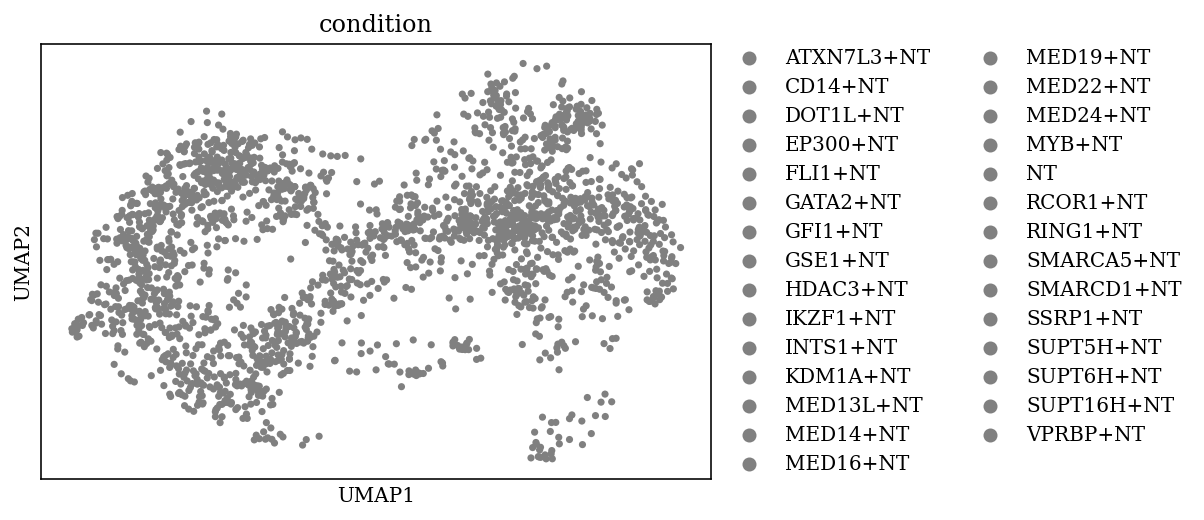

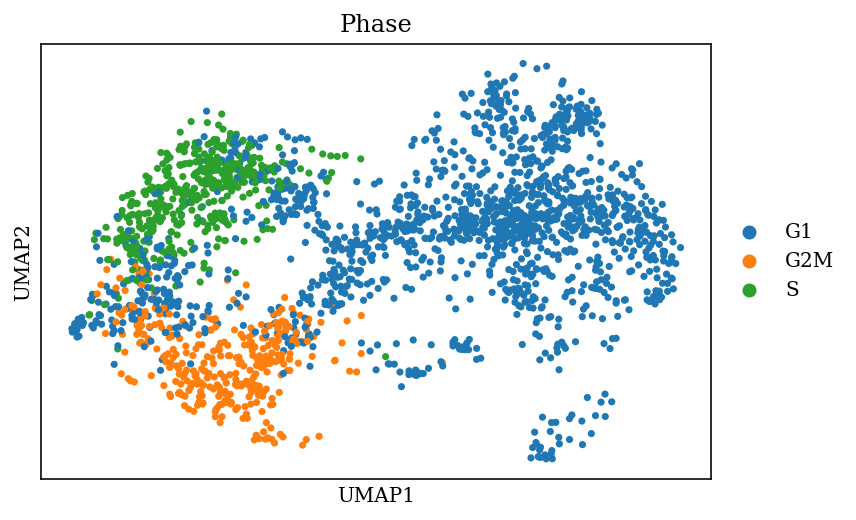

In [40]:
m = adata[adata.obs['Combination']]
for color in colors:
    sc.pl.umap(m, color=color, color_map='magma');

In [41]:
pal = sns.color_palette('gray', len(m.uns['Phase_colors']))
m.uns['Phase_colors'] = list(pal.as_hex())
pal = sns.color_palette('tab10', len(m.uns['condition_colors']))
m.uns['condition_colors'] = list(pal.as_hex())

/home/icb/kemal.inecik/miniconda3/envs/multicpa_env/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


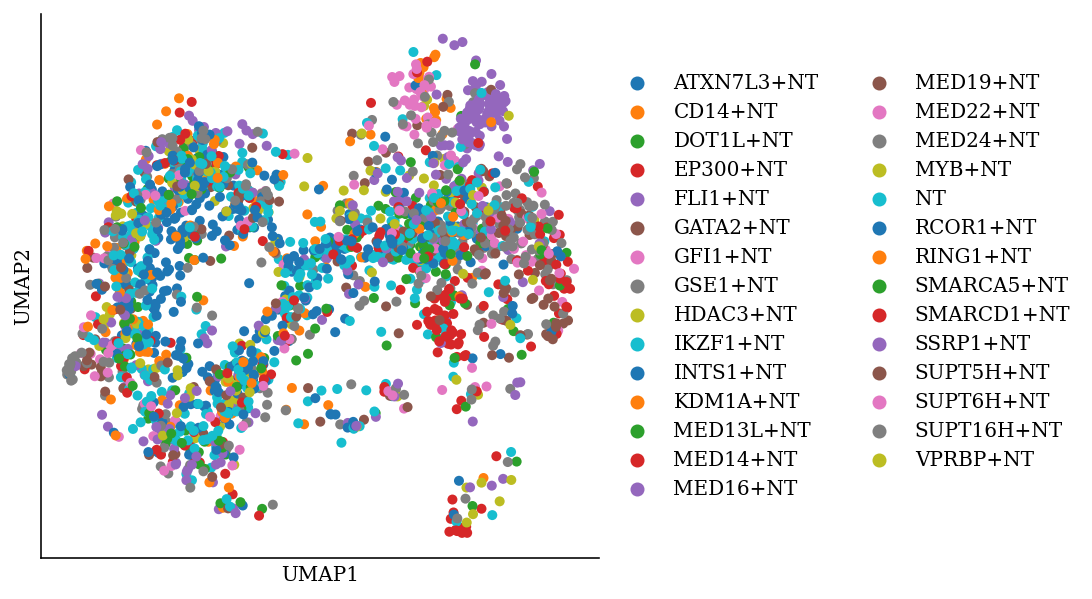

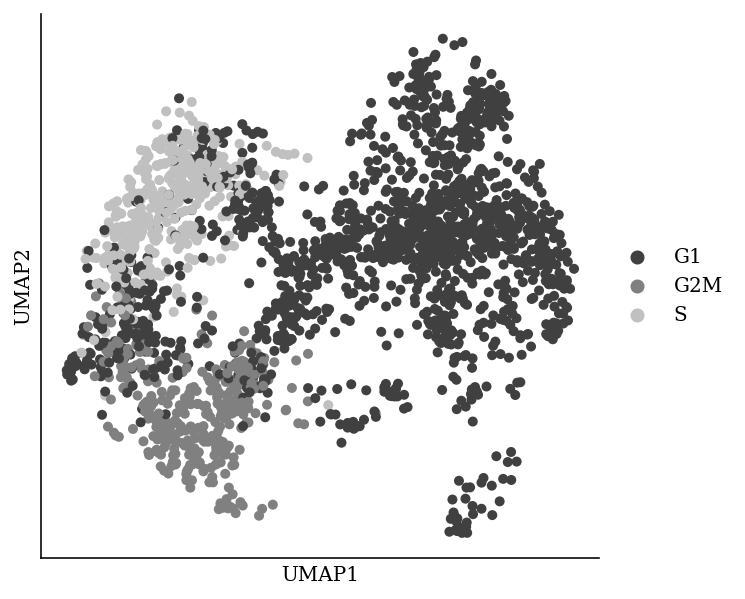

In [42]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (5,5)
}):
    for color in colors:
        sc.pl.umap(m, color=color, size=100, title='', save=f'figures/wessel_single_{color}.pdf')

In [38]:
#for color in colors:
#    sc.pl.umap(cpa_latent_treated, color=color, color_map='magma', title=f'CPA - {color}')
#    sc.pl.umap(mul_latent_treated, color=color, color_map='magma', title=f'MulPert - {color}')

# Plots

In [39]:
#raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
#adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))
#adata = adata[adata.obs['split'] == 'train']
#sc.pp.pca(adata)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

In [40]:
#with plt.style.context({'figure.figsize':(5, 5)}):
#    for color in colors + ["replicate"]:
#        sc.pl.umap(adata, color=color,ncols=1)

In [43]:
cpa_compert_api = ComPertAPI(cpa_datasets, cpa_autoencoder)
mul_compert_api = ComPertAPI(mul_datasets, mul_autoencoder)

Print and plot drug embeddings.

In [44]:
mul_perts_anndata = mul_compert_api.get_drug_embeddings()
print(mul_perts_anndata)
cpa_perts_anndata = cpa_compert_api.get_drug_embeddings()
print(cpa_perts_anndata)

AnnData object with n_obs × n_vars = 29 × 256
    obs: 'condition'
AnnData object with n_obs × n_vars = 29 × 256
    obs: 'condition'


In [45]:
mul_perts_anndata.obs['gene_groups'] = [gene_groups[i] for i in mul_perts_anndata.obs['condition']]
cpa_perts_anndata.obs['gene_groups'] = [gene_groups[i] for i in cpa_perts_anndata.obs['condition']]

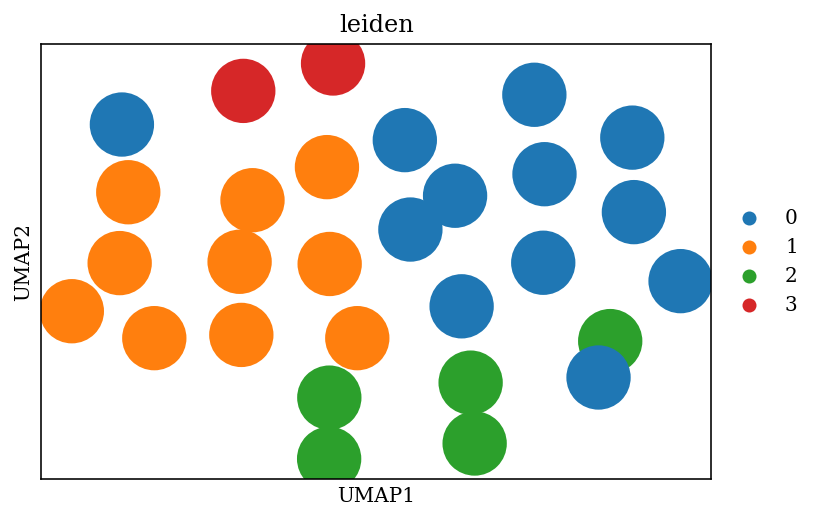

In [46]:
sc.pp.pca(mul_perts_anndata)
sc.pp.neighbors(mul_perts_anndata)
sc.tl.umap(mul_perts_anndata)
sc.tl.leiden(mul_perts_anndata)
sc.pl.umap(mul_perts_anndata, color='leiden')

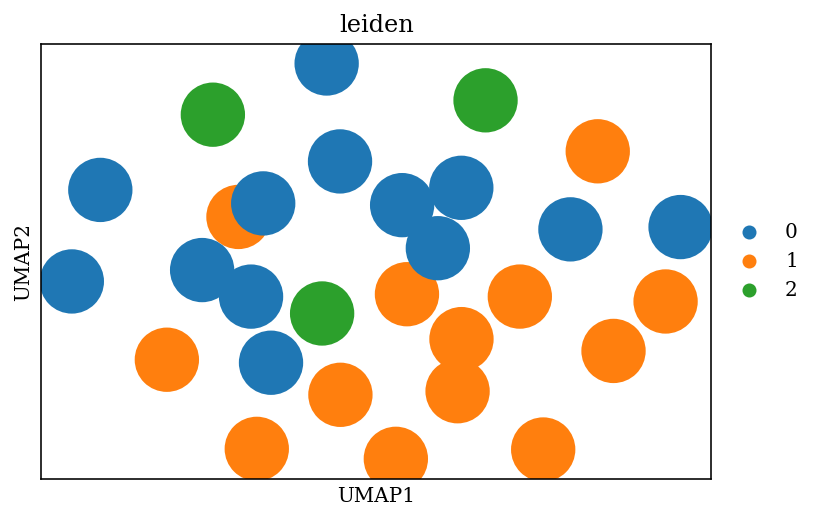

In [47]:
sc.pp.pca(cpa_perts_anndata)
sc.pp.neighbors(cpa_perts_anndata)
sc.tl.umap(cpa_perts_anndata)
sc.tl.leiden(cpa_perts_anndata)
sc.pl.umap(cpa_perts_anndata, color='leiden')

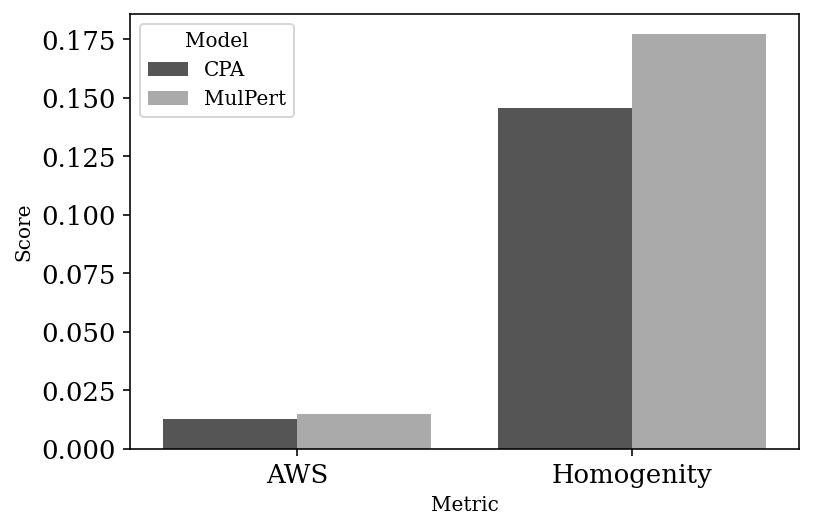

In [48]:
from sklearn.metrics import silhouette_score 
from sklearn.metrics import homogeneity_score
ss_cpa = silhouette_score(cpa_perts_anndata.X, cpa_perts_anndata.obs['leiden'])
ss_mul = silhouette_score(mul_perts_anndata.X, mul_perts_anndata.obs['leiden'])
hs_mul = homogeneity_score(mul_perts_anndata.obs['gene_groups'], mul_perts_anndata.obs['leiden'])
hs_cpa = homogeneity_score(cpa_perts_anndata.obs['gene_groups'], cpa_perts_anndata.obs['leiden'])
ss_hs = pd.DataFrame([[ss_cpa, ss_mul, hs_mul, hs_cpa], ['AWS', 'AWS', 'Homogenity', 'Homogenity'], ['CPA', 'MulPert','MulPert','CPA']]).T
ss_hs.columns = ['Score', 'Metric', "Model"]
sns.barplot(data=ss_hs, y='Score', x='Metric', hue="Model", palette='gray')
plt.show()

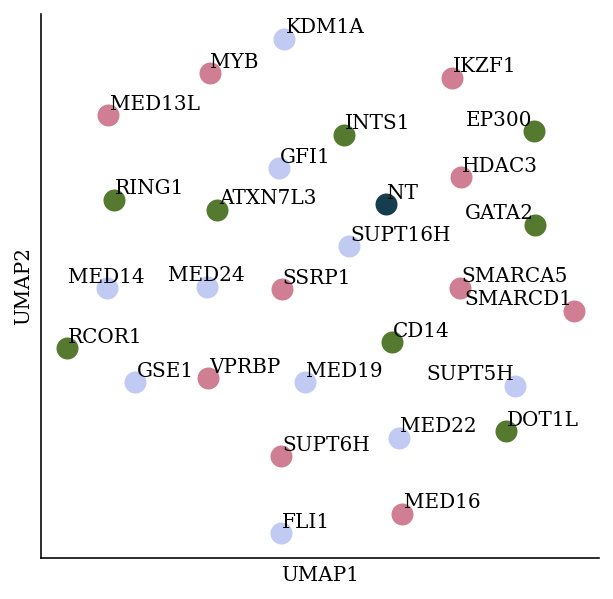

In [49]:
from adjustText import adjust_text
pal = sns.color_palette('cubehelix', 4)
mul_umap = mul_perts_anndata.obsm['X_umap'].T
with plt.rc_context({"axes.spines.right": False,"axes.spines.top": False}):
    plt.figure(figsize=(5,5))
    for ind, emm in enumerate(np.unique(mul_perts_anndata.obs['gene_groups'])):
        bop = mul_perts_anndata.obs['gene_groups'] == emm
        plt.scatter(mul_umap[0][bop], mul_umap[1][bop], color=pal[ind], s=100)
    adjust_text([plt.text(i, j, list(mul_perts_anndata.obs['condition'])[ind]) for ind, (i, j) in enumerate(mul_umap.T)])
    
    plt.gca().set_yticks([], minor=False, major=False)
    plt.gca().set_xticks([], minor=False, major=False)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.savefig(f"figures/umapfigures/wessels_drug_embedding_mulpert.pdf")

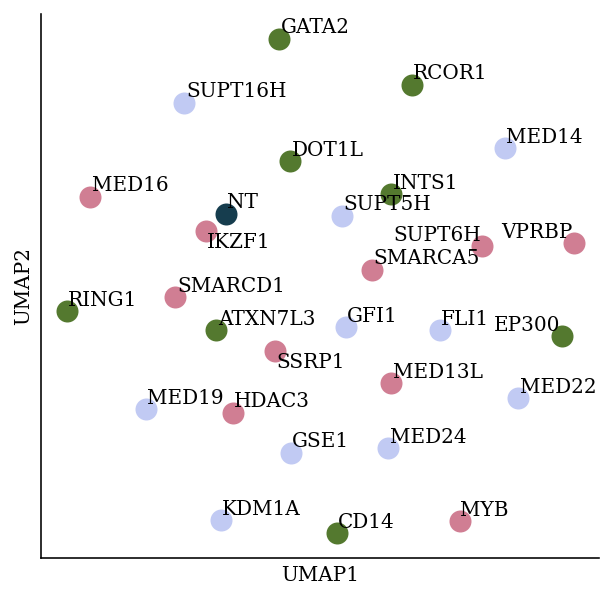

In [50]:
pal = sns.color_palette('cubehelix', 4)
mul_umap = cpa_perts_anndata.obsm['X_umap'].T
with plt.rc_context({"axes.spines.right": False,"axes.spines.top": False}):
    plt.figure(figsize=(5,5))
    for ind, emm in enumerate(np.unique(cpa_perts_anndata.obs['gene_groups'])):
        bop = cpa_perts_anndata.obs['gene_groups'] == emm
        plt.scatter(mul_umap[0][bop], mul_umap[1][bop], color=pal[ind], s=100)
    adjust_text([plt.text(i, j, list(cpa_perts_anndata.obs['condition'])[ind]) for ind, (i, j) in enumerate(mul_umap.T)])
    
    plt.gca().set_yticks([], minor=False, major=False)
    plt.gca().set_xticks([], minor=False, major=False)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.savefig(f"figures/umapfigures/wessels_drug_embedding_cpa.pdf")

Print and plot covars embeddings.

In [51]:
# Calculate the visualizations
sc.pp.pca(mul_perts_anndata)
sc.pp.neighbors(mul_perts_anndata)
sc.tl.umap(mul_perts_anndata)
# Calculate the visualizations
sc.pp.pca(cpa_perts_anndata)
sc.pp.neighbors(cpa_perts_anndata)
sc.tl.umap(cpa_perts_anndata)

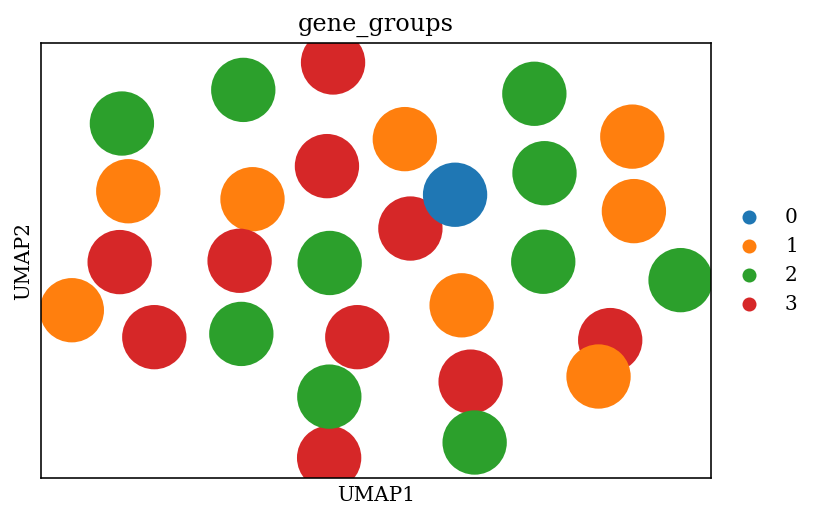

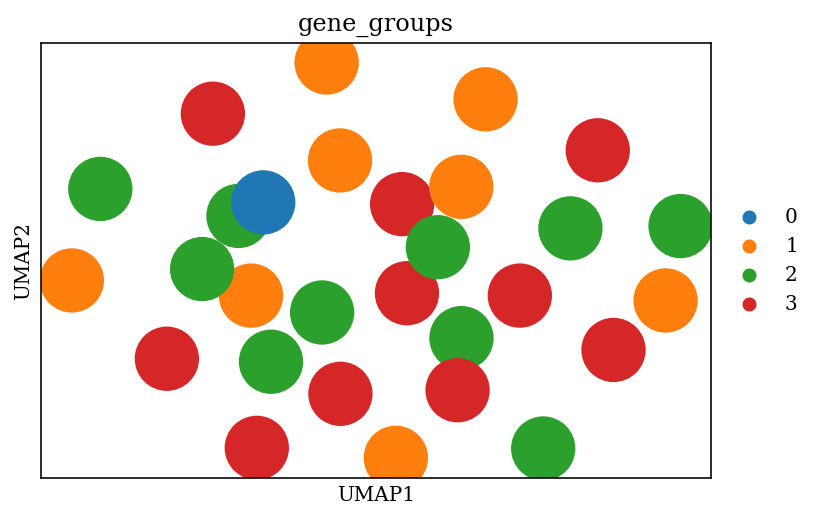

In [52]:
sc.pl.umap(mul_perts_anndata, color='gene_groups')
sc.pl.umap(cpa_perts_anndata, color='gene_groups')

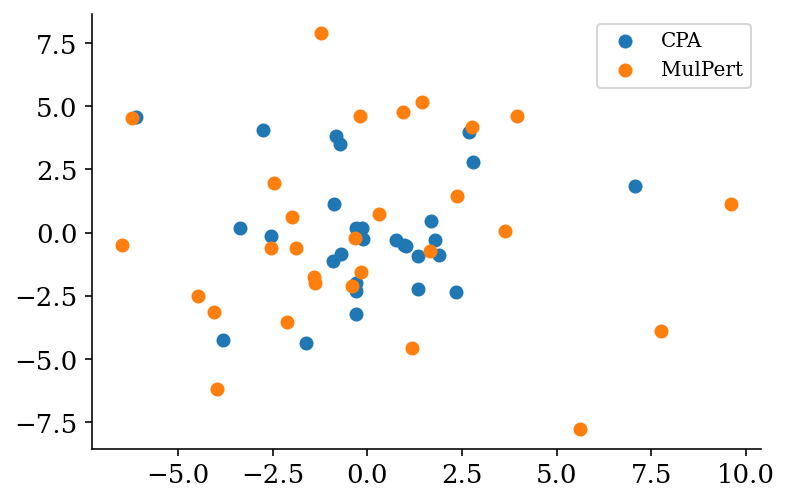

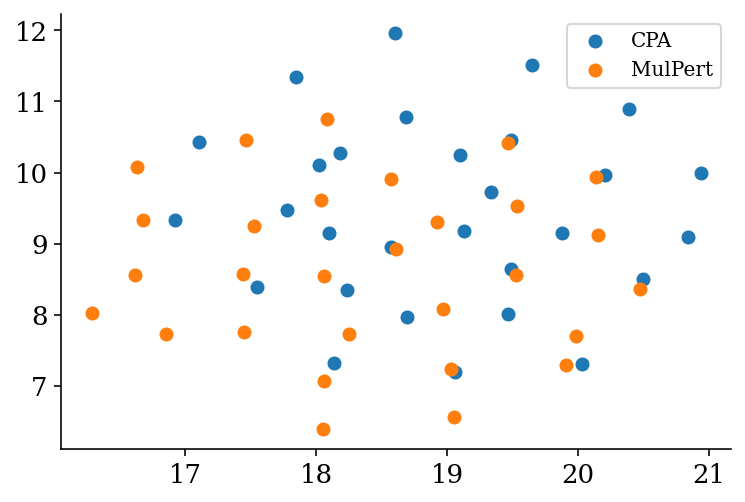

In [53]:
cpa_umap = cpa_perts_anndata.obsm['X_pca'].T
mul_umap = mul_perts_anndata.obsm['X_pca'].T
with plt.rc_context({"axes.spines.right": False,"axes.spines.top": False}):
    plt.scatter(cpa_umap[0], cpa_umap[1], label="CPA")
    plt.scatter(mul_umap[0], mul_umap[1], label="MulPert")
    plt.legend(); plt.show()
cpa_umap = cpa_perts_anndata.obsm['X_umap'].T
mul_umap = mul_perts_anndata.obsm['X_umap'].T
with plt.rc_context({"axes.spines.right": False,"axes.spines.top": False}):
    plt.scatter(cpa_umap[0], cpa_umap[1], label="CPA")
    plt.scatter(mul_umap[0], mul_umap[1], label="MulPert")
    plt.legend(); plt.show()

In [54]:
#sc.pl.pca_scatter(mul_perts_anndata)
#sc.pl.umap(mul_perts_anndata, legend_loc='on data')
#sc.pl.pca_scatter(cpa_perts_anndata)
#sc.pl.umap(cpa_perts_anndata)

In [55]:
cpa_covars_anndata = cpa_compert_api.get_covars_embeddings()
mul_covars_anndata = mul_compert_api.get_covars_embeddings()

In [56]:
print(len(mul_compert_api.num_measured_points['training']))
print(len(cpa_compert_api.num_measured_points['training']))

183
183


In [57]:
mul_compert_api.perts_dict.keys()

dict_keys(['KDM1A', 'SUPT5H', 'SUPT16H', 'RING1', 'MYB', 'CD14', 'GATA2', 'ATXN7L3', 'MED13L', 'VPRBP', 'MED22', 'IKZF1', 'FLI1', 'GSE1', 'MED14', 'MED24', 'EP300', 'GFI1', 'MED16', 'HDAC3', 'DOT1L', 'SUPT6H', 'MED19', 'SMARCD1', 'RCOR1', 'NT', 'INTS1', 'SSRP1', 'SMARCA5'])

In [58]:
mul_compert_api.compute_uncertainty(cov='THP-1', pert="DOT1L+FLI1", dose='1.0+1.0')

(1.1920929e-07, 0.0, 'THP-1_DOT1L+FLI1_1+1', 'THP-1_DOT1L+FLI1_1+1')

In [59]:
mul_compert_api.compute_comb_emb(thrh=0)
cpa_compert_api.compute_comb_emb(thrh=0)
unc = []
for i in mul_compert_api.perts_dict.keys():
    mcu = mul_compert_api.compute_uncertainty(cov='THP-1', pert=i, dose='1.0')
    ccu = cpa_compert_api.compute_uncertainty(cov='THP-1', pert=i, dose='1.0')
    unc.append([i, mcu[0], ccu[0], mcu[1], ccu[1]])
    
am = pd.DataFrame(unc, columns=["Perturbation", "mul_min_cos_dist", "cpa_min_cos_dist", "mul_min_eucl_dist", "cpa_min_eucl_dist"])
#am["cpa_min_eucl_dist"] = am["cpa_min_eucl_dist"] / 256
#am["mul_min_eucl_dist"] = am["mul_min_eucl_dist"] / 512
print(am[["mul_min_cos_dist", "cpa_min_cos_dist", "mul_min_eucl_dist", "cpa_min_eucl_dist"]].mean(0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    amk_1 = am[['Perturbation', 'mul_min_cos_dist']]
    amk_1.columns = ['Perturbation', 'Distance']
    amk_1["Model"] = 'MulPert'
    amk_1["Metric"] = 'Cosine'

    amk_2 = am[['Perturbation', 'cpa_min_cos_dist']]
    amk_2.columns = ['Perturbation', 'Distance']
    amk_2["Model"] = 'CPA'
    amk_2["Metric"] = 'Cosine'

    amk_3 = am[['Perturbation', 'mul_min_eucl_dist']]
    amk_3.columns = ['Perturbation', 'Distance']
    amk_3["Model"] = 'MulPert'
    amk_3["Metric"] = 'Euclidean'

    amk_4 = am[['Perturbation', 'cpa_min_eucl_dist']]
    amk_4.columns = ['Perturbation', 'Distance']
    amk_4["Model"] = 'CPA'
    amk_4["Metric"] = 'Euclidean'

amk = pd.concat([amk_1, amk_2, amk_3, amk_4])
amk.reset_index(inplace=True, drop=True)
amk = amk.sort_values(by=["Perturbation", "Model"])
amk = amk[amk["Perturbation"] != "NT"]

mul_min_cos_dist      0.249942
cpa_min_cos_dist      0.269772
mul_min_eucl_dist    14.253432
cpa_min_eucl_dist     8.960764
dtype: float32


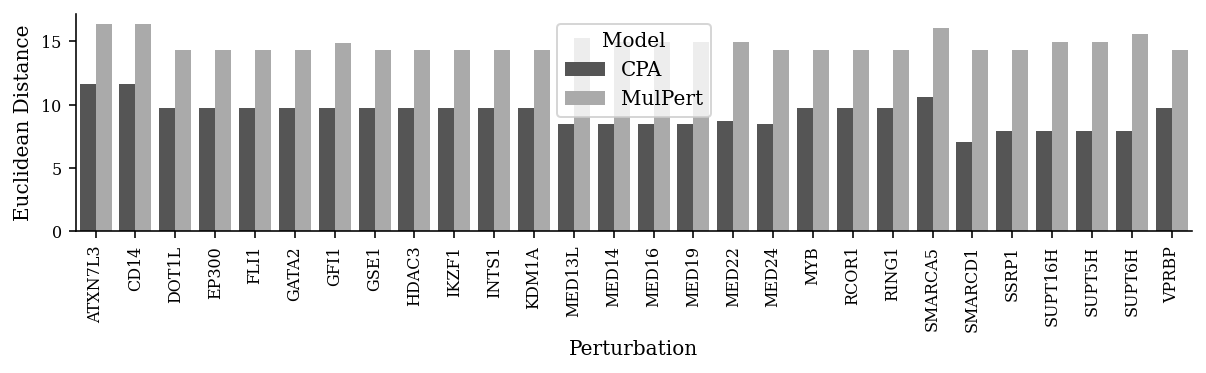

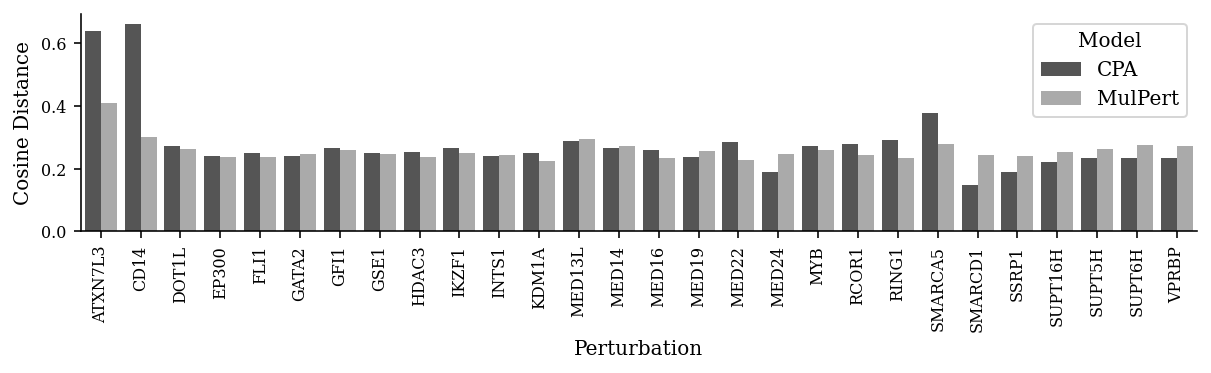

In [60]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(10, 2))
    sns.barplot(data=amk[amk['Metric'] == 'Euclidean'], y='Distance', x='Perturbation', hue='Model', palette='gray')
    plt.ylabel("Euclidean Distance")
    plt.xticks(rotation=90)
    plt.gca().tick_params(axis='both',labelsize=8)
    plt.show()

with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(10, 2))
    sns.barplot(data=amk[amk['Metric'] == 'Cosine'], y='Distance', x='Perturbation', hue='Model', palette='gray')
    plt.ylabel("Cosine Distance")
    plt.xticks(rotation=90)
    plt.gca().tick_params(axis='both',labelsize=8)
    plt.show()

# eukledian distance is normalized with latent dim!!!!

Setting up a variable for automatic plotting. The plots also could be used separately.

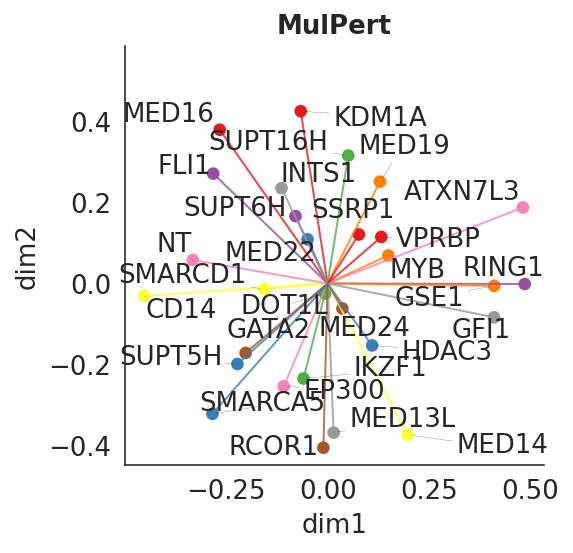

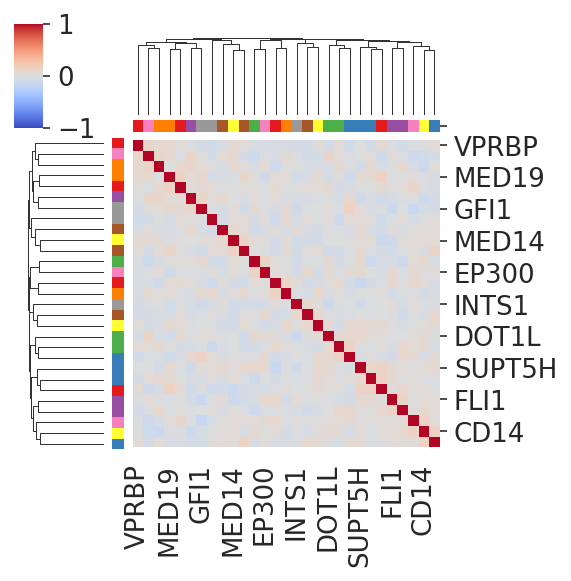

In [61]:
mul_compert_plots = CompertVisuals(mul_compert_api, fileprefix=None)
mul_compert_plots.plot_latent_embeddings(mul_compert_api.emb_perts, 
                                         kind='perturbations', 
                                         show_text=True,
                                        titlename='MulPert')

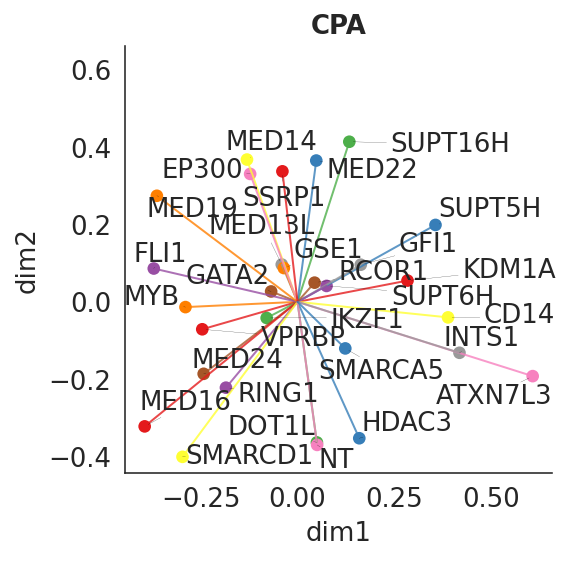

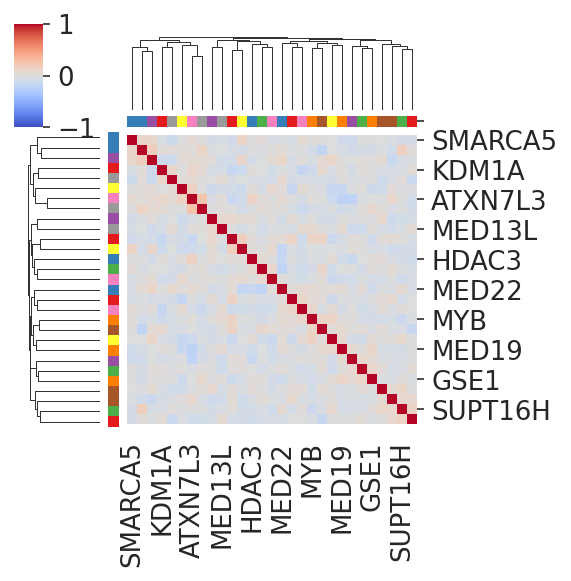

In [62]:
cpa_compert_plots = CompertVisuals(cpa_compert_api, fileprefix=None)
cpa_compert_plots.plot_latent_embeddings(cpa_compert_api.emb_perts, 
                                         kind='perturbations', 
                                         show_text=True, 
                                        titlename='CPA')

If your have a lot of cell types or a lot of perturbations, you can also chose to not display their names.

In [63]:
#compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=False)

Or I can change the color scheme for the emebddings.

In [64]:
perts_palette_ = {'0': '#999999',                 
                 '1': '#4daf4a',
                 '2': '#377eb8',
                 '3': '#e41a1c',
                }
perts_palette = {i:perts_palette_[gene_groups[i]] for i in gene_groups}

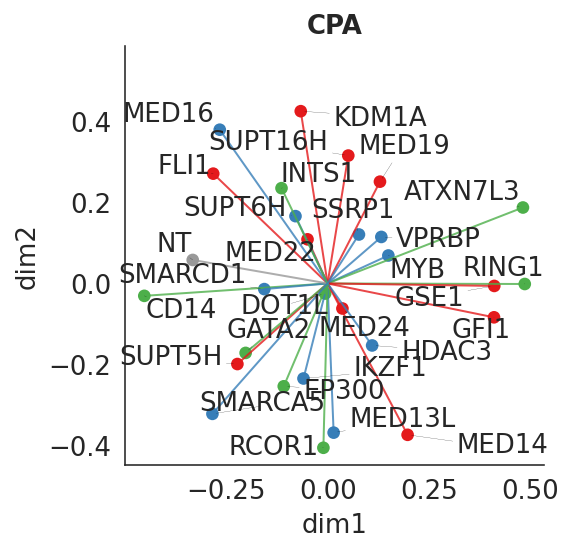

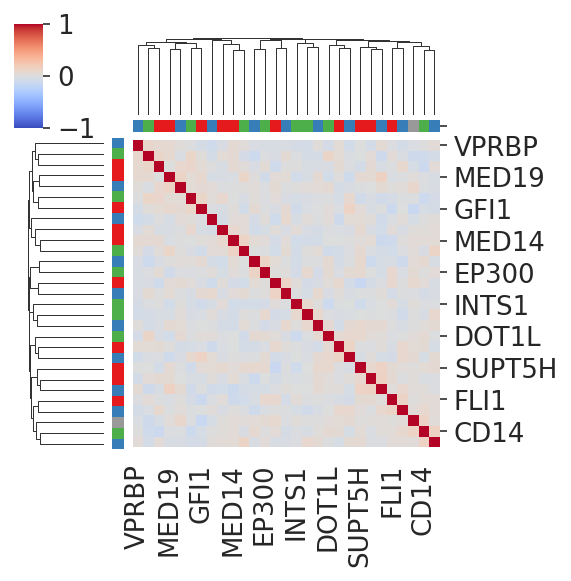

In [65]:
mul_compert_plots.perts_palette = perts_palette
mul_compert_plots.plot_latent_embeddings(mul_compert_api.emb_perts, 
                                         kind='perturbations', 
                                         show_text=True, 
                                        titlename='CPA')

# OOD predictions

In [74]:
raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))

adata.X = adata.layers['counts'].copy()
adata.obsm["protein_expression"] = adata.obsm["protein_expression_raw"].copy()
del adata.layers['counts']
del adata.obsm["protein_expression_raw"]

adata.obsm['protein_expression'] = pd.DataFrame(adata.obsm['protein_expression'].astype(int), index=adata.obs.index, columns=adata.uns['protein_names'])
adata.X = adata.X.A.astype(int)
de_genes = adata.uns["rank_genes_groups_cov"].copy()
del adata.uns
del adata.var
adata.obs = adata.obs[['cov_drug_dose_name', 'control', 'split2']]
adata.obs.columns = ['batch', 'control', 'split2']
adata.uns["rank_genes_groups_cov"] = de_genes

#### CPA

In [75]:
dataset = cpa_datasets["ood"]
genes_control = cpa_datasets["test_control"].raw_genes
proteins_control = cpa_datasets["test_control"].raw_proteins
num, dim_genes = genes_control.size(0), genes_control.size(1)
dim_proteins = proteins_control.size(1)
assert np.all(cpa_datasets["test_control"].var_names == adata.var.index) # for mm consistency

mean_score_proteins = []
mean_score_genes = []
mean_score_genes_de = []
perts_mul = []
for pert_category in sorted(np.unique(dataset.pert_categories)):
    de_idx = np.where(dataset.var_names.isin(np.array(dataset.de_genes[pert_category])))[0]
    idx = np.where(dataset.pert_categories == pert_category)[0]
    
    if len(idx) > 30:
        perts_mul.append(pert_category)
        
        emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
        emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

        gene_predictions, protein_predictions = cpa_autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
        gene_predictions = gene_predictions.detach().cpu()
        protein_predictions = protein_predictions.detach().cpu()

        mean_predict_genes = gene_predictions[:, :dim_genes]
        mean_predict_proteins = protein_predictions[:, :dim_proteins]

        y_true_genes = dataset.raw_genes[idx, :].numpy()
        yt_m_genes = y_true_genes.mean(axis=0)
        yp_m_genes = np.array(mean_predict_genes.mean(0))
        mean_score_genes.append(r2_score(yt_m_genes, yp_m_genes))
        mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))  

In [76]:
m_1 = pd.concat([
    pd.DataFrame([perts_mul, mean_score_genes, ["All Genes"] * len(mean_score_genes)]).T,
    pd.DataFrame([perts_mul, mean_score_genes_de, ["DE Genes"] * len(mean_score_genes_de)]).T
])
m_1["Model"] = "CPA"

#### MulPert

In [77]:
dataset = mul_datasets["ood"]
genes_control = mul_datasets["test_control"].raw_genes
proteins_control = mul_datasets["test_control"].raw_proteins
num, dim_genes = genes_control.size(0), genes_control.size(1)
dim_proteins = proteins_control.size(1)
assert np.all(mul_datasets["test_control"].var_names == adata.var.index) # for mm consistency

mean_score_proteins = []
mean_score_genes = []
mean_score_genes_de = []
perts_mul = []
for pert_category in sorted(np.unique(dataset.pert_categories)):
    de_idx = np.where(dataset.var_names.isin(np.array(dataset.de_genes[pert_category])))[0]
    idx = np.where(dataset.pert_categories == pert_category)[0]
    
    if len(idx) > 30:
        perts_mul.append(pert_category)
        
        emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
        emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

        gene_predictions, protein_predictions = mul_autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
        gene_predictions = gene_predictions.detach().cpu()
        protein_predictions = protein_predictions.detach().cpu()

        mean_predict_genes = gene_predictions[:, :dim_genes]
        mean_predict_proteins = protein_predictions[:, :dim_proteins]

        y_true_genes = dataset.raw_genes[idx, :].numpy()
        yt_m_genes = y_true_genes.mean(axis=0)
        yp_m_genes = np.array(mean_predict_genes.mean(0))
        mean_score_genes.append(r2_score(yt_m_genes, yp_m_genes))
        mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))  
        
        y_true_proteins = dataset.raw_proteins[idx, :].numpy()
        yt_m_proteins = y_true_proteins.mean(axis=0)
        yp_m_proteins = mean_predict_proteins.mean(0)
        mean_score_proteins.append(r2_score(yt_m_proteins, yp_m_proteins))

In [78]:
m_2 = pd.concat([
    pd.DataFrame([perts_mul, mean_score_genes, ["All Genes"] * len(mean_score_genes)]).T,
    pd.DataFrame([perts_mul, mean_score_genes_de, ["DE Genes"] * len(mean_score_genes_de)]).T,
    pd.DataFrame([perts_mul, mean_score_proteins, ["Proteins"] * len(mean_score_proteins)]).T
])
m_2["Model"] = "MultiCPA"
m = pd.concat([m_1, m_2])
m.reset_index(inplace=True, drop=True)
m.columns = ["Perturbation", "r2 Score", "Feature Set", "Model"]

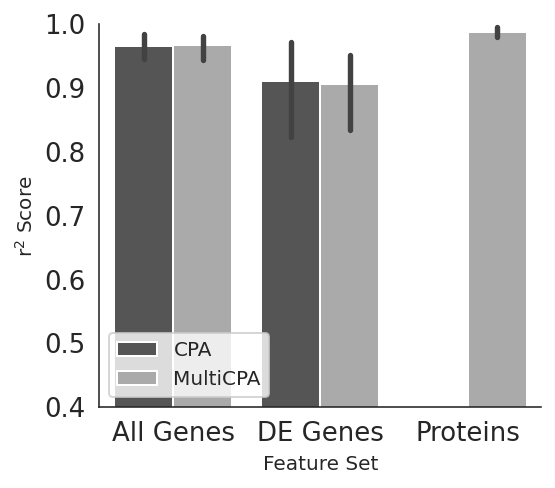

In [79]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(4, 3.5))
    g = sns.barplot(data=m, x='Feature Set', hue='Model', y='r2 Score', palette='gray')
    g.legend(loc='lower left')
    plt.ylim(0.4, 1)
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig(f"figures/ood_cpa_multicpa.pdf")